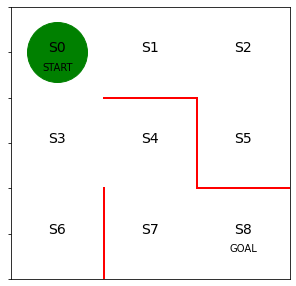

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig=plt.figure(figsize=(5,5))
ax=plt.gca()

plt.plot([1,1],[0,1],color='red',linewidth=2)
plt.plot([1,2],[2,2],color='red',linewidth=2)
plt.plot([2,2],[2,1],color='red',linewidth=2)
plt.plot([2,3],[1,1],color='red',linewidth=2)

plt.text(0.5,2.5,'S0',size=14,ha='center')
plt.text(1.5,2.5,'S1',size=14,ha='center')
plt.text(2.5,2.5,'S2',size=14,ha='center')
plt.text(0.5,1.5,'S3',size=14,ha='center')
plt.text(1.5,1.5,'S4',size=14,ha='center')
plt.text(2.5,1.5,'S5',size=14,ha='center')
plt.text(0.5,0.5,'S6',size=14,ha='center')
plt.text(1.5,0.5,'S7',size=14,ha='center')
plt.text(2.5,0.5,'S8',size=14,ha='center')
plt.text(0.5,2.3,'START',ha='center')
plt.text(2.5,0.3,'GOAL',ha='center')

ax.set_xlim(0,3)
ax.set_ylim(0,3)
plt.tick_params(axis='both',which='both',bottom=False,top=False,labelbottom=False,right=False,labelleft=False)

line,=ax.plot([0.5],[2.5],marker="o",color='g',markersize=60)

theta_0= np.array([[np.nan,1,1,np.nan],
                   [np.nan,1,np.nan,1],
                   [np.nan,1,np.nan,1],
                   [1,1,1,np.nan],
                   [np.nan,np.nan,1,1],
                   [1,np.nan,np.nan,np.nan],
                   [1,np.nan,np.nan,np.nan],
                   [1,1,np.nan,np.nan]])

[a,b]=theta_0.shape
# Q= Action valuefunction

Q=np.random.rand(a,b)*theta_0 # theta_0를 곱해줌으로서 벽은 모두 nan으로 Q를 부여




In [9]:
def pi_from_theta(theta):
  [m,n]=theta.shape
  pi=np.zeros((m,n))
  for i in range(m):
    pi[i,:]=theta[i,:]/np.nansum(theta[i,:])
  pi=np.nan_to_num(pi)
  return pi

def softmax_pi_from_theta(theta):
  beta=1.0 #inverse temperature, beta가 작아지면,무작위행동의 선택확률이 올라간다.
  [m,n]=theta.shape
  pi=np.zeros((m,n))
  exp_theta=np.exp(beta*theta)
  for i in range(m):
    #pi[i,:]=theta[i,:]/np.nansum(theta[i,:]) #simple한 변환
    pi[i,:]=exp_theta[i,:]/np.nansum(exp_theta[i,:]) #nan을 0으로 변환
  pi=np.nan_to_num(pi)
  return pi
  
pi_0=pi_from_theta(theta_0)

In [ ]:
# epsilon-greedy algorithm -->epsilon-greedy exploration과 동일

def get_action(s,Q,epsilon,pi_0):
  direction=["up","right","down","left"]

  #action decision
  if np.random.rand()<epsilon:
    next_direction=np.random.choice(direction,p=pi_0[s,:])
  else: # 1-epsilon의 probability
    next_direction=direction[np.nanargmax(Q[s,:])]
  if next_direction=="up":
    action=0
  elif next_direction=="right":
    action=1
  elif next_direction=="down":
    action=2
  elif next_direction=="left":
    action=3
  return action

def get_s_next(s,a,Q,epsilon,pi_0):
  direction=["up","right","down","left"]
  next_direction=direction[a] #a의 방향
  if next_direction=="up":
    s_next=s-3
  elif next_direction=="right":
    s_next=s+1
  elif next_direction=="down":
    s_next=s+3
  elif next_direction=="left":
    s_next=s-1
  return s_next

In [ ]:
def Sarsa(s,a,r,s_next,a_next,Q,eta,gamma): #gamma는 discount factor, eta는 learning rate
  if s_next==8:
    Q[s,a]=Q[s,a]+eta*(r-Q[s,a])
  else:
    Q[s,a]=Q[s,a]+eta*(r+gamma*Q[s_next,a_next]-Q[s,a]) # TD error : r+gamma*Q[s_next,a_next]-Q[s,a]
  return Q


In [ ]:
#Game Play

def goal_maze_ret_s_a_Q(Q,epsilon,eta,gamma,pi):
  s=0 #start point
  a=a_next=get_action(s,Q,epsilon,pi) #첫 행동 결정
  s_a_history=[[0,np.nan]]
  while(1):
    a=a_next #행동 결정
    s_a_history[-1][1]=a # np.nan으로 비워둔 history에 action 저장

    s_next=get_s_next(s,a,Q,epsilon,pi) #action 이후 state 획득

    s_a_history.append([s_next,np.nan]) #action 결정되지 않음 but history에 state저장

    if s_next==8: #도착지점 도착시
      r=1
      a_next=np.nan #종료하였으므로 a_next는 없음
    else:
      r=0
      a_next=get_action(s_next,Q,epsilon,pi)
    
    Q=Sarsa(s,a,r,s_next,a_next,Q,eta,gamma)

    if s_next==8: #Q 업데이트 후 종료
      break
    else:
      s=s_next #state update
  return [s_a_history, Q]


In [10]:
eta=0.1 #learning rate
gamma=0.9 # discount rate
epsilon=0.5 # epsilon-greedy algorithm initial value
is_continue=True
episode =1
v=np.nanmax(Q,axis=1)

while is_continue:
  print("episode:"+str(episode))

  epsilon=epsilon/2 # greedy 하기 위해서 argmax한 Q를 선택할 확률이 증가함
  [s_a_history,Q]=goal_maze_ret_s_a_Q(Q,epsilon,eta,gamma,pi_0)

  new_v= np.nanmax(Q,axis=1) # Q function의 max값 확인 action value function의 max값을 계산
  print(np.sum(np.abs(new_v-v))) # action value function 의 변화 출력
  v=new_v
  print("목표지점까지의 단계수: "+str(len(s_a_history)-1))
  episode=episode+1
  if episode>100:
    break

  



episode:1
7.131019363892932e-08
목표지점까지의 단계수: 4
episode:2
6.511286287924634e-08
목표지점까지의 단계수: 4
episode:3
5.945002345963957e-08
목표지점까지의 단계수: 4
episode:4
5.427597271623341e-08
목표지점까지의 단계수: 4
episode:5
4.954887833363841e-08
목표지점까지의 단계수: 4
episode:6
4.5230453382671953e-08
목표지점까지의 단계수: 4
episode:7
4.128565966876607e-08
목표지점까지의 단계수: 4
episode:8
3.768243461710341e-08
목표지점까지의 단계수: 4
episode:9
3.4391442249592785e-08
목표지점까지의 단계수: 4
episode:10
3.1385842147457765e-08
목표지점까지의 단계수: 4
episode:11
2.8641081173397254e-08
목표지점까지의 단계수: 4
episode:12
2.6134699182556176e-08
목표지점까지의 단계수: 4
episode:13
2.3846153052176078e-08
목표지점까지의 단계수: 4
episode:14
2.1756654922100438e-08
목표지점까지의 단계수: 4
episode:15
1.9849022869777855e-08
목표지점까지의 단계수: 4
episode:16
1.810754624020916e-08
목표지점까지의 단계수: 4
episode:17
1.6517859191544915e-08
목표지점까지의 단계수: 4
episode:18
1.506682856255992e-08
목표지점까지의 단계수: 4
episode:19
1.3742447513287459e-08
목표지점까지의 단계수: 4
episode:20
1.2533740934017601e-08
목표지점까지의 단계수: 4
episode:21
1.1430676960522135e-08
목표지점